# Notes
* Make sure to use the `dlr` conda environment when running this notebook

# Imports

In [1]:
#%% Imports
import numpy as np
import pandas as pd
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from rex import WindX, NSRDBX
## Local
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from dlr import physics
from dlr import plots

### Format plots
plots.plotparams()

#%%### Shared settings
temp_conductor = 75 + physics.C2K
diameter_conductor = 0.03
absorptivity_conductor = 0.8
emissivity_conductor = 0.8
FOOT_PER_METER = 3.28084

# Get weather data for a single site

In [2]:
lat, lon = 39.7407295, -105.1712073
lat_lon = (lat, lon)
year = 2012
fpaths = {
    'nsrdb': f"/nrel/nsrdb/v3/nsrdb_{year}.h5",
    'wtk': f"/nrel/wtk/conus/wtk_conus_{year}.h5",
}
with NSRDBX(fpaths['nsrdb'], hsds=True) as f:
    dfsolar = f.get_lat_lon_df('ghi', lat_lon).iloc[::2].squeeze(1).rename('ghi').to_frame()

with WindX(fpaths['wtk'], hsds=True) as f:
    dfwind = pd.concat({
        param.split('_')[0]: f.get_lat_lon_df(param, lat_lon)
        for param in ['windspeed_10m','winddirection_10m','pressure_0m','temperature_10m']
    }, axis=1).droplevel(level=1, axis=1)

## Convert °C to K
dfwind['temperature'] += physics.C2K

# Wind rose
Bar height scales with prevailing wind strength from the corresponding direction

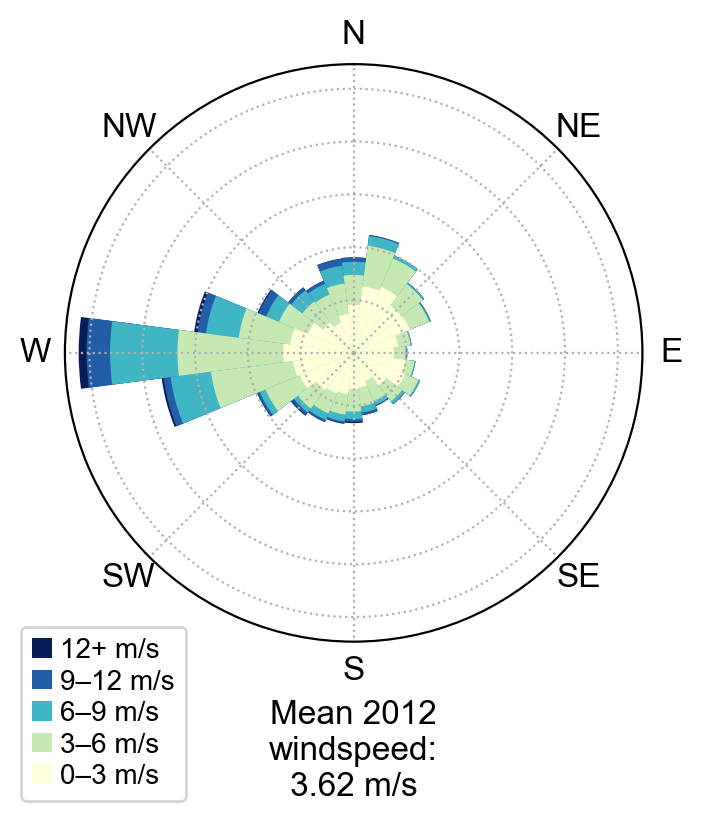

In [3]:
plt.close()
ax = plots.plot_windrose(
    dfwind=dfwind.windspeed,
    dfdir=dfwind.winddirection,
    legend_kwargs={
        'loc':'lower left', 'bbox_to_anchor':(-0.1, -0.3),
        'handletextpad':0.3, 'handlelength':0.7,
        'labelspacing':0.2,
    }
)
ax.annotate(
    f'Mean {year}\nwindspeed:\n{dfwind.windspeed.mean():.2f} m/s',
    (0.5,-0.1), xycoords='axes fraction',
    ha='center', va='top', fontsize=12,
)
plt.show()

# Distribution of ratings

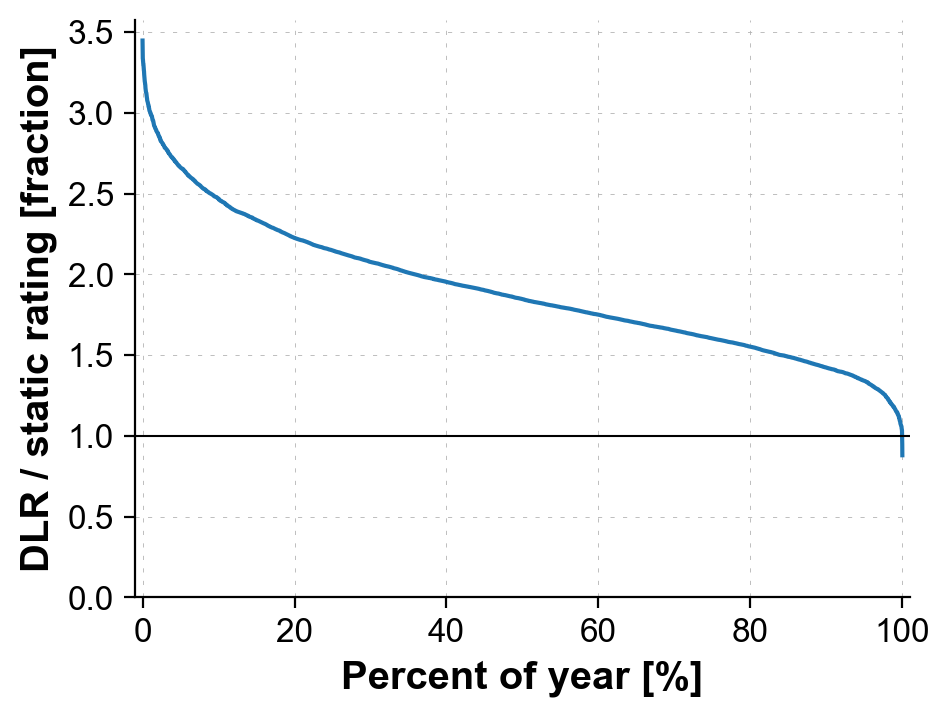

In [4]:
## Calculate rating
line_angle = 90
ampacity = physics.ampacity(
    windspeed=dfwind.windspeed,
    wind_conductor_angle=(dfwind.winddirection - line_angle),
    pressure=dfwind.pressure,
    temp_ambient_air=dfwind.temperature,
    solar_ghi=dfsolar.ghi,
)
ampacity_static = physics.ampacity()
dfplot = pd.concat({'A':ampacity, 'fraction':ampacity/ampacity_static}, axis=1)

#%% Plot distribution of ratings
plt.close()
f,ax = plt.subplots()
ax.plot(
    np.linspace(0,100,len(dfplot)),
    dfplot.fraction.sort_values(ascending=False),
)
ax.axhline(1, c='k', ls='-', lw=0.75)
ax.set_xlim(-1,101)
ax.set_ylim(0)
ax.set_ylabel('DLR / static rating [fraction]')
ax.set_xlabel('Percent of year [%]')
ax.grid(which='major', c='0.7', ls=(0, (5, 10)), lw=0.3)
plots.despine(ax)
plt.show()

# Full-year timeseries of ratings

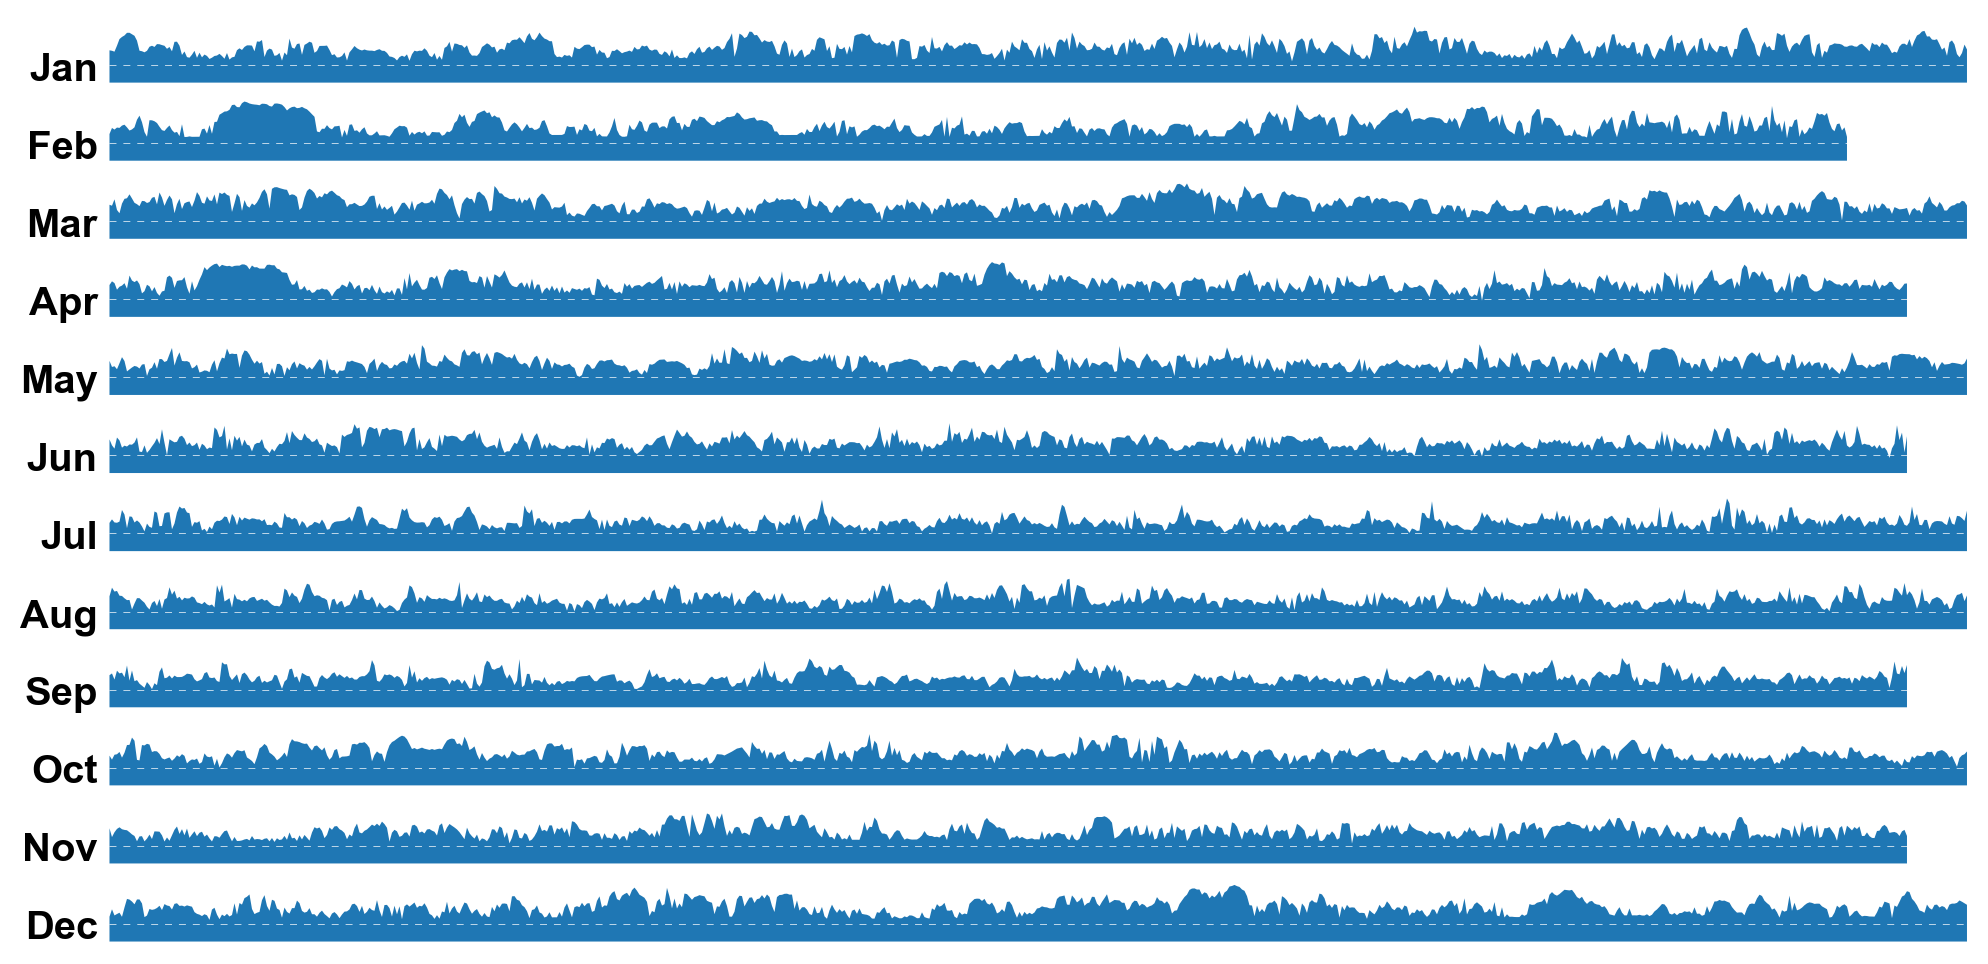

In [5]:
plt.close()
f,ax = plots.plotyearbymonth(dfplot.fraction)
for row in range(12):
    ax[row].axhline(1, c='w', ls=(0,(10,10)), lw=0.25)
plt.show()

# Coincident hourly weather and ratings

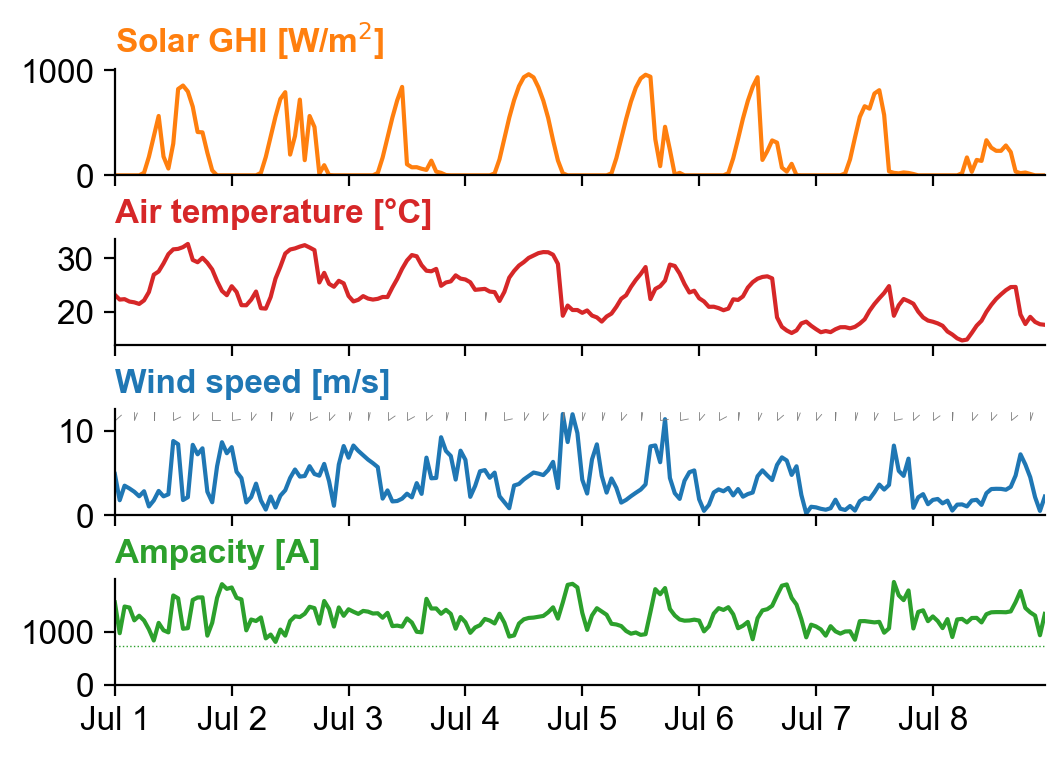

In [6]:
#%% Plot a smaller timeseries
dmin, dmax = '2012-07-01', '2012-07-08'
df = (
    pd.concat([dfplot, dfsolar, dfwind], axis=1)
    .tz_convert('US/Mountain')
    .loc[dmin:dmax]
)
## Wrap around 90
wind_line_angle_in_180 = np.remainder(abs(df.winddirection - line_angle), 180)
wind_line_angle_in_90 = 90 - abs(wind_line_angle_in_180 - 90)
df['wind_line_rad'] =  np.deg2rad(wind_line_angle_in_90)

freq_arrow = 4

plt.close()
f,ax = plt.subplots(4, 1, figsize=(6,4), sharex=True, gridspec_kw={'hspace':0.6})
## Solar
ax[0].plot(df.index, df.ghi, color='C1')
ax[0].set_title('Solar GHI [W/m'+r'$^2$'+']', x=0, ha='left', color='C1', weight='bold')
ax[0].set_ylim(0)
## Temperature
ax[1].plot(df.index, df.temperature-physics.C2K, color='C3')
ax[1].set_title('Air temperature [°C]', x=0, ha='left', color='C3', weight='bold')
## Windspeed
ax[2].plot(df.index, df.windspeed, color='C0')
ax[2].set_title('Wind speed [m/s]', x=0, ha='left', color='C0', weight='bold')
ax[2].set_ylim(0)
ymax = ax[2].get_ylim()[1]
## Wind direction
for t, row in df.iloc[::freq_arrow].iterrows():
    ax[2].plot(
        [t], [ymax*0.9],
        marker=[(0,1), (0,0), (np.sin(row.wind_line_rad),np.cos(row.wind_line_rad))],
        markeredgewidth=0.3, markerfacecolor='none', markeredgecolor='C7',
    )
## Ampacity
ax[3].plot(df.index, df.A, color='C2')
ax[3].set_title('Ampacity [A]', x=0, ha='left', color='C2', weight='bold')
ax[3].set_ylim(0)
ax[3].axhline(ampacity_static, c='C2', ls=':', lw=0.5)
## Formatting
ax[0].set_xlim(df.index[0], df.index[-1])
ax[-1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %-d'))
plots.despine(ax)
plt.show()

# Sensitivity analysis: Weather parameters

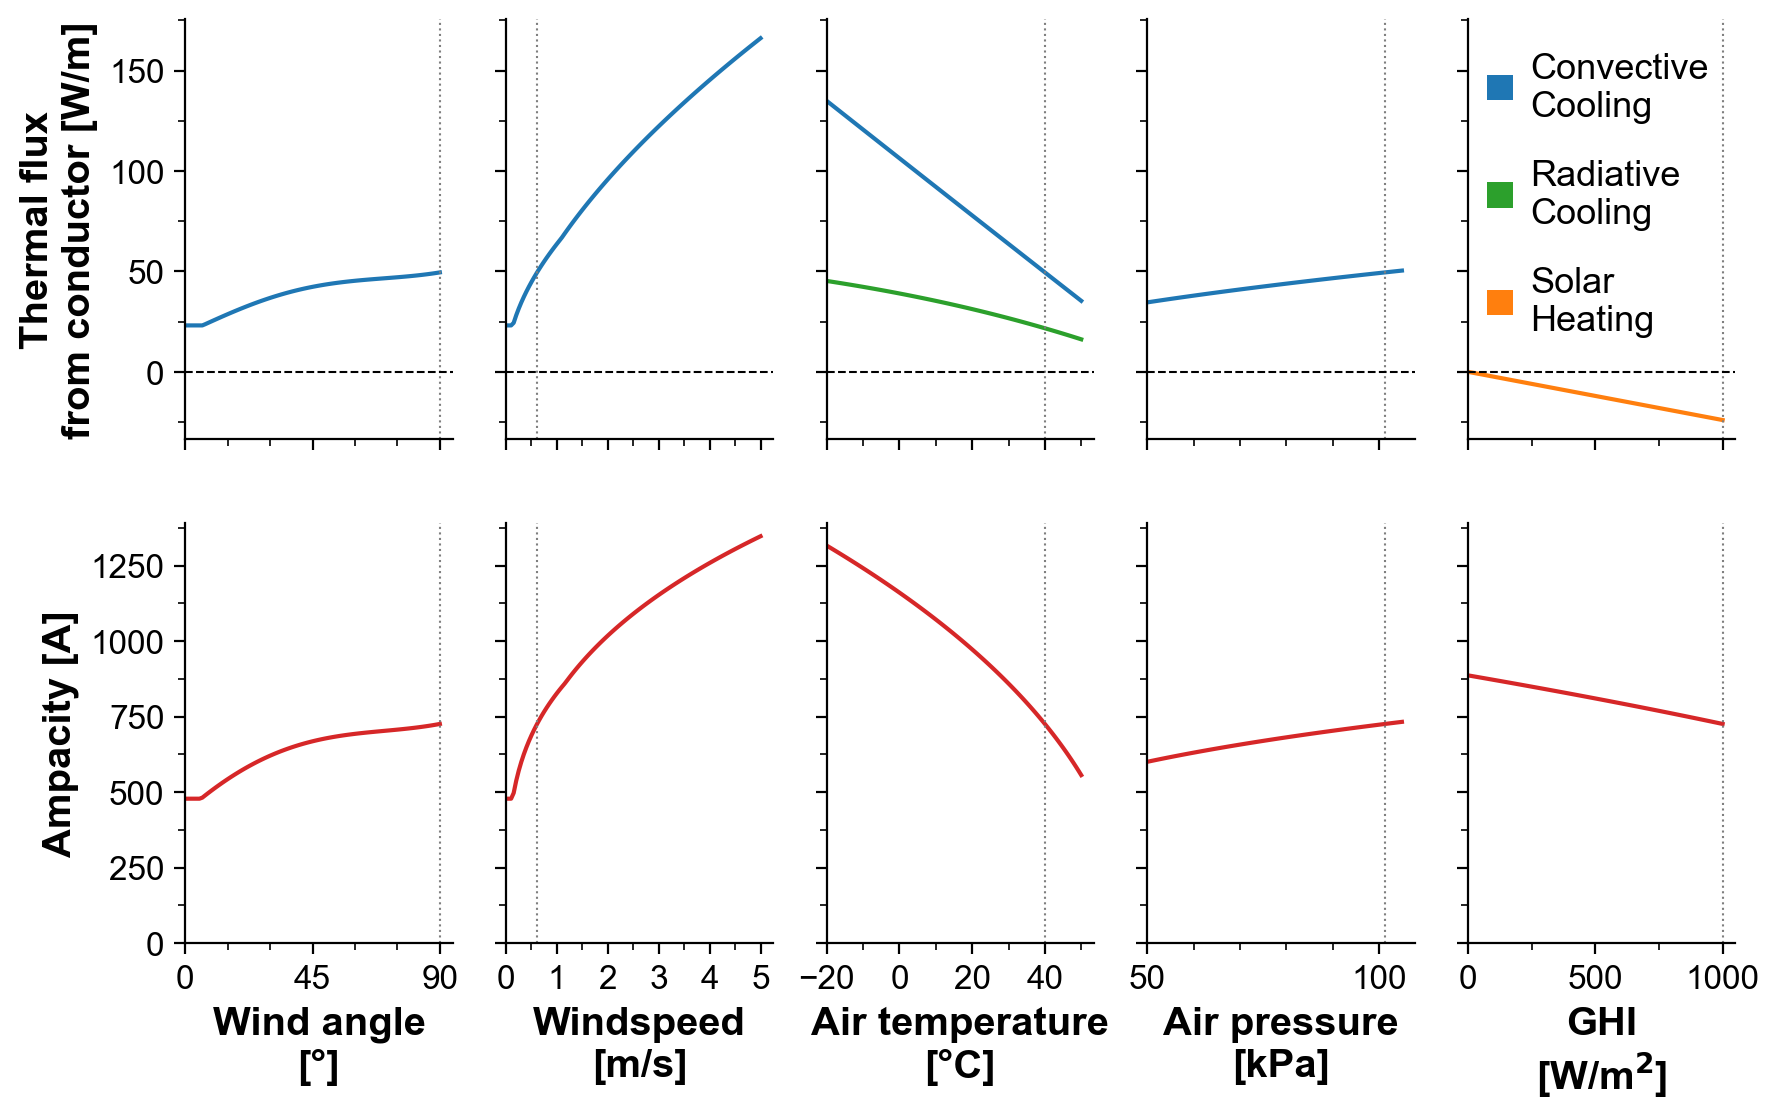

In [7]:
mults = np.linspace(1, 2, 101)
allmults = np.array(sorted(set(list(1 / mults) + list(mults))))

angles = np.arange(0, 90.0001, 1)
windspeeds = np.linspace(0, 5, 101)
temp_ambient_airs = np.linspace(-20, 50, 101)
pressures = np.linspace(50, 105, 101)
ghis = np.linspace(0, 1000, 101)

defaults = {
    'phi': 90,
    'windspeed': 0.61,
    "temp_ambient_air": 40,
    'pressure': 101.3529,
    "ghi": 1000,
}

params = {
    "phi": {
        'data': pd.DataFrame({**defaults, **{"phi": angles}}),
        'title': "Wind angle [°]",
        'value': ['convective_cooling'],
        'major_locator': 45,
        'minor_locator': 15,
    },
    "windspeed": {
        'data': pd.DataFrame({**defaults, **{"windspeed": windspeeds}}),
        'title': "Windspeed [m/s]",
        'value': ['convective_cooling'],
        'major_locator': 1,
        'minor_locator': 0.5,
    },
    "temp_ambient_air": {
        'data': pd.DataFrame({**defaults, **{"temp_ambient_air": temp_ambient_airs}}),
        'title': "Air temperature [°C]",
        'value': ['convective_cooling','radiative_cooling'],
        'major_locator': 20,
        'minor_locator': 10,
    },
    "pressure": {
        'data': pd.DataFrame({**defaults, **{"pressure": pressures}}),
        'title': "Air pressure [kPa]",
        'value': ['convective_cooling'],
        'minor_locator': 10,
    },
    "ghi": {
        'data': pd.DataFrame({**defaults, **{"ghi": ghis}}),
        'title': "GHI [W/m" + r"$\bf{^2}$" + "]",
        'value': ['solar_heating'],
        'major_locator': 500,
        'minor_locator': 250,
    },
}
colors = {
    'convective_cooling': 'C0',
    'radiative_cooling': 'C2',
    'solar_heating': 'C1',
    'ampacity': 'C3',
}

plt.close()
f, ax = plt.subplots(2, len(params), sharex='col', sharey='row', figsize=(10, 6))
for col, (param, values) in enumerate(params.items()):
    df = values['data']
    df["wind_direction_factor"] = physics.get_wind_direction_factor(df["phi"])
    df["T_film"] = physics.get_film_temperature(
        temp_conductor, df["temp_ambient_air"] + physics.C2K)
    df["density_air"] = physics.get_air_density_ideal(
        pressure=df.pressure*1e3,
        temperature=df.T_film,
    )
    df["convective_cooling"] = physics.convective_cooling_ieee(
        temp_conductor=temp_conductor,
        diameter_conductor=diameter_conductor,
        windspeed=df.windspeed,
        wind_direction_factor=df.wind_direction_factor,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
        density_air=df.density_air,
    )
    df["solar_heating"] = -physics.solar_heating(
        solar_ghi=df.ghi,
        diameter_conductor=diameter_conductor,
        absorptivity_conductor=absorptivity_conductor,
    )
    df['radiative_cooling'] = physics.radiative_cooling(
        diameter_conductor=diameter_conductor,
        emissivity_conductor=emissivity_conductor,
        temp_surface=temp_conductor,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
    )
    df['ampacity'] = physics.ampacity(
        windspeed=df.windspeed,
        wind_conductor_angle=df.phi,
        pressure=df.pressure*1e3,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
        solar_ghi=df.ghi,
    )
    ### Flux
    for value in params[param]['value']:
        ax[0,col].plot(
            df[param].values, df[value].values,
            c=colors[value], label=value.title().replace('_',' '),
        )
    ### Ampacity
    ax[1,col].plot(
        df[param].values, df['ampacity'].values,
        c=colors['ampacity'], label='Ampacity',
    )
    ## Formatting
    for row in range(2):
        ax[row,col].axvline(defaults[param], c="C7", ls=":", lw=0.75)
        ax[row,col].set_xlim(min(df[param].values))
    ax[0,col].axhline(0, c="k", ls="--", lw=0.75)
    ax[-1,col].set_xlabel(params[param]['title'].replace(' [','\n['))
    if 'major_locator' in values:
        ax[-1,col].xaxis.set_major_locator(mpl.ticker.MultipleLocator(values['major_locator']))
    if 'minor_locator' in values:
        ax[-1,col].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(values['minor_locator']))

## Custom legend
handles = [
    mpl.patches.Patch(
        facecolor=colors[c], edgecolor='none',
        label=c.title().replace('_','\n'),
    )
    for c in colors if c != 'ampacity'
]
ax[0,-1].legend(
    handles=handles, loc='upper left', bbox_to_anchor=(-0.05,1),
    frameon=False, fontsize=13,
    handletextpad=0.5, handlelength=0.7, labelspacing=1.0,
)
## Formatting
for row in range(2):
    ax[row,0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[1,0].set_ylim(0)
ax[0,0].set_ylabel("Thermal flux\nfrom conductor [W/m]")
ax[1,0].set_ylabel("Ampacity [A]")
# ax[0].set_ylim(0)
plots.despine(ax)
plt.show()

# Sensitivity analysis: Conductor parameters

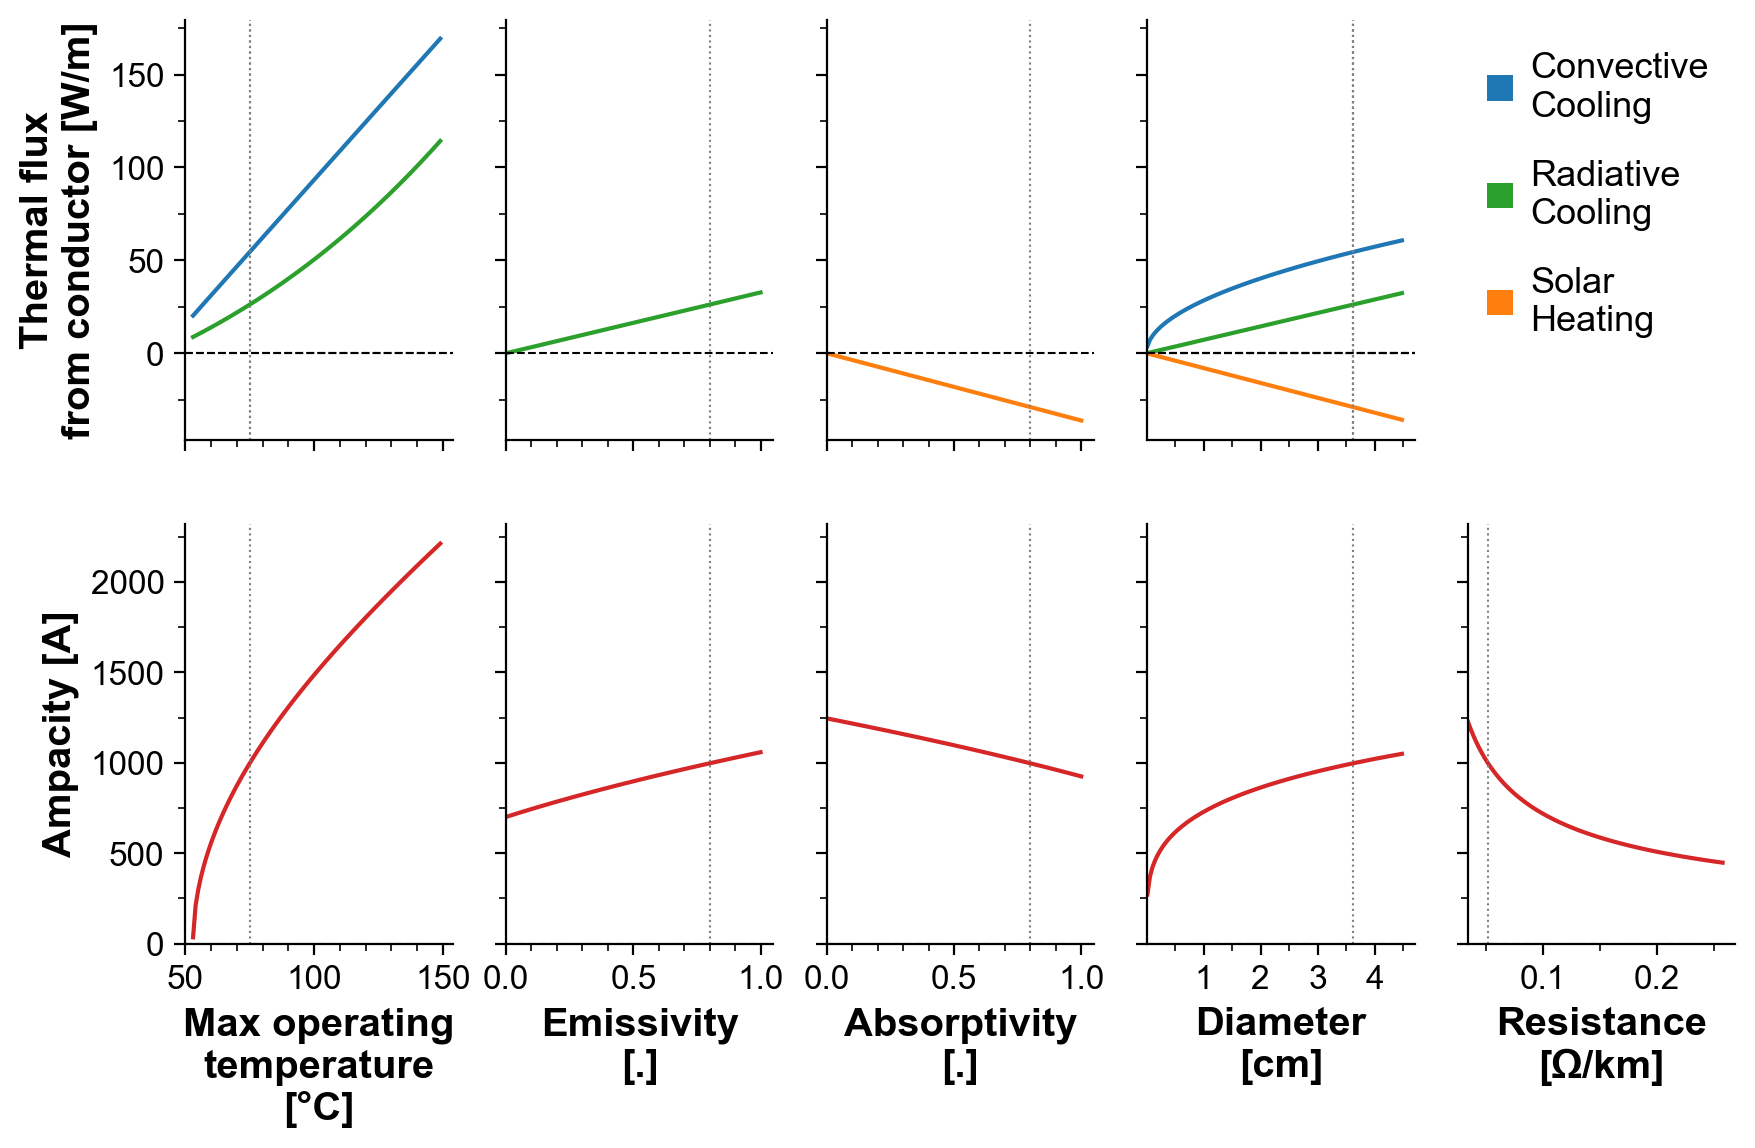

In [8]:
mults = np.linspace(1, 2, 101)
allmults = np.array(sorted(set(list(1 / mults) + list(mults))))

conductor_temps = np.arange(53, 150, 1)
emissivities = np.linspace(0, 1, 101)
absorptivities = np.linspace(0, 1, 101)
diameters = np.linspace(
    0.00503 / 12 / FOOT_PER_METER,
    1.762 / 12 / FOOT_PER_METER,
    101) * 100
resistances = np.linspace(
    3.44488e-5,
    0.000258,
    101) * 1000

defaults = {
    'phi': 90,
    'windspeed': 0.61,
    "temp_ambient_air": 40,
    'pressure': 101.3529,
    "ghi": 1000,
    'temp_conductor': 75,
    'emissivity_conductor': 0.8,
    'absorptivity_conductor': 0.8,
    # ## Defaults
    # 'diameter_conductor': 0.02814*100,
    # 'R': 8.688e-5*1000,
    # ## 345 kV
    # 'diameter_conductor': 0.0304*100,
    # 'R': 0.000073*1000,
    ## 230 kV
    'diameter_conductor': 0.0362*100,
    'R': 0.000052*1000,
}

params = {
    "temp_conductor": {
        'data': pd.DataFrame({**defaults, **{"temp_conductor": conductor_temps}}),
        'title': "Max operating\ntemperature [°C]",
        'value': ['convective_cooling','radiative_cooling'],
        'major_locator': 50,
        'minor_locator': 10,
    },
    "emissivity_conductor": {
        'data': pd.DataFrame({**defaults, **{"emissivity_conductor": emissivities}}),
        'title': "Emissivity\n[.]",
        'value': ['radiative_cooling'],
        'major_locator': 0.5,
        'minor_locator': 0.1,
    },
    "absorptivity_conductor": {
        'data': pd.DataFrame({**defaults, **{"absorptivity_conductor": absorptivities}}),
        'title': "Absorptivity\n[.]",
        'value': ['solar_heating'],
        'major_locator': 0.5,
        'minor_locator': 0.1,
    },
    "diameter_conductor": {
        'data': pd.DataFrame({**defaults, **{"diameter_conductor": diameters}}),
        'title': "Diameter\n[cm]",
        'value': ['convective_cooling','radiative_cooling','solar_heating'],
        'major_locator': 1.0,
        'minor_locator': 0.5,
    },
    "R": {
        'data': pd.DataFrame({**defaults, **{"R": resistances}}),
        'title': "Resistance\n[Ω/km]",
        'value': [],
        'major_locator': 0.1,
        'minor_locator': 0.05,
    },
}
colors = {
    'convective_cooling': 'C0',
    'radiative_cooling': 'C2',
    'solar_heating': 'C1',
    'ampacity': 'C3',
}

plt.close()
f, ax = plt.subplots(2, len(params), sharex='col', sharey='row', figsize=(10, 6))
for col, (param, values) in enumerate(params.items()):
    df = values['data']
    df["wind_direction_factor"] = physics.get_wind_direction_factor(df["phi"])
    df["T_film"] = physics.get_film_temperature(
        temp_conductor=df.temp_conductor + physics.C2K,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
    )
    df["density_air"] = physics.get_air_density_ideal(
        pressure=df.pressure*1e3,
        temperature=df.T_film,
    )
    df["convective_cooling"] = physics.convective_cooling_ieee(
        temp_conductor=df.temp_conductor + physics.C2K,
        diameter_conductor=df.diameter_conductor/100,
        windspeed=df.windspeed,
        wind_direction_factor=df.wind_direction_factor,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
        density_air=df.density_air,
    )
    df["solar_heating"] = -physics.solar_heating(
        solar_ghi=df.ghi,
        diameter_conductor=df.diameter_conductor/100,
        absorptivity_conductor=df.absorptivity_conductor,
    )
    df['radiative_cooling'] = physics.radiative_cooling(
        diameter_conductor=df.diameter_conductor/100,
        emissivity_conductor=df.emissivity_conductor,
        temp_surface=df.temp_conductor + physics.C2K,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
    )
    df['ampacity'] = physics.ampacity(
        windspeed=df.windspeed,
        pressure=df.pressure*1e3,
        temp_ambient_air=df.temp_ambient_air + physics.C2K,
        wind_conductor_angle=df.phi,
        solar_ghi=df.ghi,
        temp_conductor=df.temp_conductor + physics.C2K,
        diameter_conductor=df.diameter_conductor/100,
        resistance_conductor=df.R/1000,
        emissivity_conductor=df.emissivity_conductor,
        absorptivity_conductor=df.absorptivity_conductor,
    )
    ### Flux
    for value in params[param]['value']:
        ax[0,col].plot(
            df[param].values, df[value].values,
            c=colors[value], label=value.title().replace('_',' '),
        )
        ax[0,col].axvline(defaults[param], c="C7", ls=":", lw=0.75)
        ax[0,col].axhline(0, c="k", ls="--", lw=0.75)
    if not len(params[param]['value']):
        ax[0,col].axis('off')
    ### Ampacity
    ax[1,col].plot(
        df[param].values, df['ampacity'].values,
        c=colors['ampacity'], label='Ampacity',
    )
    ## Formatting
    ax[1,col].axvline(defaults[param], c="C7", ls=":", lw=0.75)
    ax[1,col].axhline(0, c="k", ls="--", lw=0.75)
    for row in range(2):
        ax[row,col].set_xlim(min(df[param].values))
    ax[-1,col].set_xlabel(params[param]['title'].replace(' [','\n['))
    if 'major_locator' in values:
        ax[-1,col].xaxis.set_major_locator(mpl.ticker.MultipleLocator(values['major_locator']))
    if 'minor_locator' in values:
        ax[-1,col].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(values['minor_locator']))

## Custom legend
handles = [
    mpl.patches.Patch(
        facecolor=colors[c], edgecolor='none',
        label=c.title().replace('_','\n'),
    )
    for c in colors if c != 'ampacity'
]
ax[0,-1].legend(
    handles=handles, loc='upper left', bbox_to_anchor=(-0.05,1),
    frameon=False, fontsize=13,
    handletextpad=0.5, handlelength=0.7, labelspacing=1.0,
)
## Formatting
for row in range(2):
    ax[row,0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[1,0].set_ylim(0)
ax[1,0].set_xlim(50)
ax[0,0].set_ylabel("Thermal flux\nfrom conductor [W/m]")
ax[1,0].set_ylabel("Ampacity [A]")
plots.despine(ax)
plt.show()